### Imports

In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['OPENBLAS_NUM_THREADS'] = '16'  
from os.path import join
import numpy as np
from tqdm import tqdm
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt


import MAS_library as MASL
import Pk_library as PKL
import redshift_space_library as RSL
from omegaconf import OmegaConf
import h5py

os.chdir('/home/mattho/git/ltu-cmass/matts_tests')


In [2]:
wdir = '/automnt/data80/mattho/cmass-ili'

### Load training and test data

In [6]:
def get_cosmo(source_path):
    cfg = OmegaConf.load(join(source_path, 'config.yaml'))
    return np.array(cfg.nbody.cosmo)

def get_halo_Pk(source_path):
    diag_file = join(source_path, 'diag', 'halos.h5')
    if not os.path.exists(diag_file):
        return None, None, None
    with h5py.File(diag_file, 'r') as f:
        a = list(f.keys())[-1]
        k = f[a]['Pk_k'][:]
        Pk = f[a]['Pk'][:]
    cosmo = get_cosmo(source_path)
    return k, Pk, cosmo

In [7]:
# Training suite
suite = 'quijotelike'
sim = 'fastpm'
L, N = 1000, 128

from cmass.utils import get_source_path

suite_path = get_source_path(wdir, suite, sim, L, N, 0)[:-2]


ktrain, Pktrain, cosmotrain = [], [], []
for lhid in tqdm(os.listdir(suite_path)):
    k, Pk, cosmo = get_halo_Pk(join(suite_path, lhid))
    ktrain.append(k)
    Pktrain.append(Pk)
    cosmotrain.append(cosmo)

ktrain, Pktrain, cosmotrain = map(lambda x: [i for i in x if i is not None], [ktrain, Pktrain, cosmotrain])
ktrain, Pktrain, cosmotrain = map(np.stack, [ktrain, Pktrain, cosmotrain])
print(ktrain.shape, Pktrain.shape, cosmotrain.shape)

  1%|▏         | 25/2000 [00:01<01:23, 23.69it/s]

100%|██████████| 2000/2000 [01:03<00:00, 31.74it/s]

(2000, 110) (2000, 110, 3) (2000, 5)


In [8]:
# Test suite
suite = 'quijote'
sim = 'nbody'
L, N = 1000, 128

from cmass.utils import get_source_path

suite_path = get_source_path(wdir, suite, sim, L, N, 0)[:-2]


ktest, Pktest, cosmotest = [], [], []
for lhid in tqdm(os.listdir(suite_path)):
    k, Pk, cosmo = get_halo_Pk(join(suite_path, lhid))
    ktest.append(k)
    Pktest.append(Pk)
    cosmotest.append(cosmo)

ktest, Pktest, cosmotest = map(lambda x: [i for i in x if i is not None], [ktest, Pktest, cosmotest])
ktest, Pktest, cosmotest = map(np.stack, [ktest, Pktest, cosmotest])
print(ktest.shape, Pktest.shape, cosmotest.shape)

100%|██████████| 2000/2000 [01:00<00:00, 33.21it/s] 

(1903, 110) (1903, 110, 3) (1903, 5)


/tmp/ipykernel_1791311/4278353457.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap('viridis')


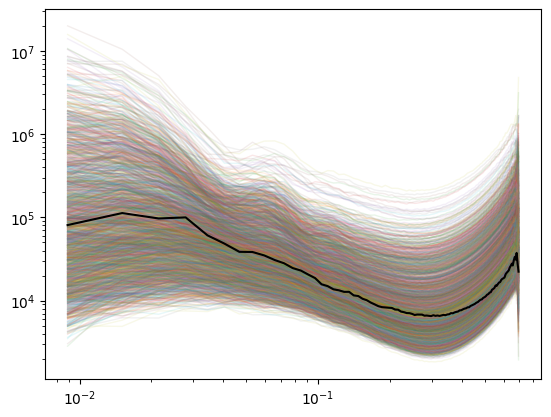

In [9]:
l = 10

f, ax = plt.subplots()
cmap = mpl.cm.get_cmap('viridis')
Om = cosmotrain[:,0]
for k, Pk, cosmo in zip(ktrain, Pktrain[...,0], Om):
    omnorm = (Om-Om.min())/(Om.max()-Om.min())
    ax.loglog(k, Pk, lw=1, alpha=0.1)
ax.loglog(ktest[l], Pktest[l,...,0], 'k')

### Train

In [10]:
import ili
from ili.dataloaders import NumpyLoader
from ili.inference import InferenceRunner
from ili.validation.metrics import PosteriorCoverage, PlotSinglePosterior
from ili.embedding import FCN
device='cpu'

def run_inference(x, theta):
    loader = NumpyLoader(x=x, theta=theta)

    # define a prior
    prior = ili.utils.Uniform(
        low=theta.min(axis=0),
        high=theta.max(axis=0),
        device=device)

    embedding = FCN(n_hidden=[64, 32, 16], act_fn='ReLU')

    # instantiate your neural networks to be used as an ensemble
    nets = [
        ili.utils.load_nde_lampe(
            model='maf', hidden_features=50, num_transforms=5,
            embedding_net=embedding),
        # ili.utils.load_nde_lampe(model='gf', hidden_features=50, num_transforms=5)
    ]

    # define training arguments
    train_args = {
        'training_batch_size': 32,
        'learning_rate': 5e-5
    }

    # initialize the trainer
    runner = InferenceRunner.load(
        backend='lampe',
        engine='NPE',
        prior=prior,
        nets=nets,
        device=device,
        train_args=train_args
    )

    # train the model
    posterior_ensemble, summaries = runner(loader=loader)

    return posterior_ensemble, summaries

/data80/mattho/anaconda3/envs/cmass/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
# train at different resolutions
kmaxs = [0.1, 0.2, 0.4, 0.6]

# impute with mean
def impute(arr):
    # Compute the mean of each row, ignoring nan values
    col_mean = np.nanmean(arr, axis=1)
    
    # Find the indices where values are nan
    inds = np.where(np.isnan(arr))
    
    # Replace nan values with the mean of the respective column
    arr[inds] = np.take(col_mean, inds[0])
    return arr

In [12]:
posteriors, summaries = {}, {}
for kmax in kmaxs:
    print(f'Training for kmax={kmax}')

    # focus on the monopole
    x = Pktrain[:, :, 0]

    # cut on k
    mask = ktrain[0] < kmax
    x = x[:, mask]
    theta = cosmotrain

    # log
    x = np.log10(x)

    # impute
    x = impute(x)

    # train
    _p, _s = run_inference(x, theta)
    posteriors[kmax] = _p
    summaries[kmax] = _s


INFO:root:MODEL INFERENCE CLASS: NPE


Training for kmax=0.1


INFO:root:Training model 1 / 1.
11 epochs [00:06,  2.00 epochs/s, loss=-7.21, loss_val=-7.31]

844 epochs [07:45,  1.81 epochs/s, loss=-11.4, loss_val=-11]  
INFO:root:It took 465.44960737228394 seconds to train models.
INFO:root:MODEL INFERENCE CLASS: NPE
INFO:root:Training model 1 / 1.


Training for kmax=0.2


720 epochs [08:08,  1.47 epochs/s, loss=-12.5, loss_val=-12.3]
INFO:root:It took 488.40781450271606 seconds to train models.
INFO:root:MODEL INFERENCE CLASS: NPE
INFO:root:Training model 1 / 1.


Training for kmax=0.4


558 epochs [05:45,  1.61 epochs/s, loss=-12.5, loss_val=-12.2]
INFO:root:It took 345.7333643436432 seconds to train models.
INFO:root:MODEL INFERENCE CLASS: NPE
INFO:root:Training model 1 / 1.


Training for kmax=0.6


608 epochs [06:03,  1.67 epochs/s, loss=-12.9, loss_val=-12.6]
INFO:root:It took 363.6933515071869 seconds to train models.


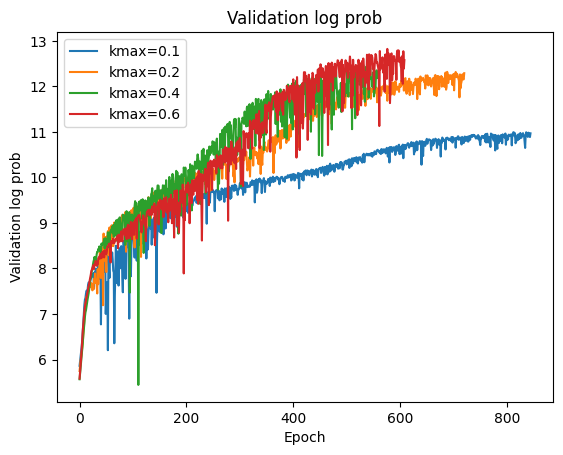

In [13]:
# plot loss functions
f, ax = plt.subplots()
for kmax in kmaxs:
    ax.plot(summaries[kmax][0]['validation_log_probs'], label=f'kmax={kmax}')
ax.set(xlabel='Epoch', ylabel='Validation log prob', title='Validation log prob')
ax.legend()

### Plot

INFO:root:Sampling models with tensor([1000.]) samples each.


0.1


Drawing 1000 posterior samples: 1100it [00:02, 477.66it/s]                         
INFO:root:Sampling models with tensor([1000.]) samples each.


0.2


Drawing 1000 posterior samples: 1254it [00:01, 938.12it/s]                         


KeyboardInterrupt: 

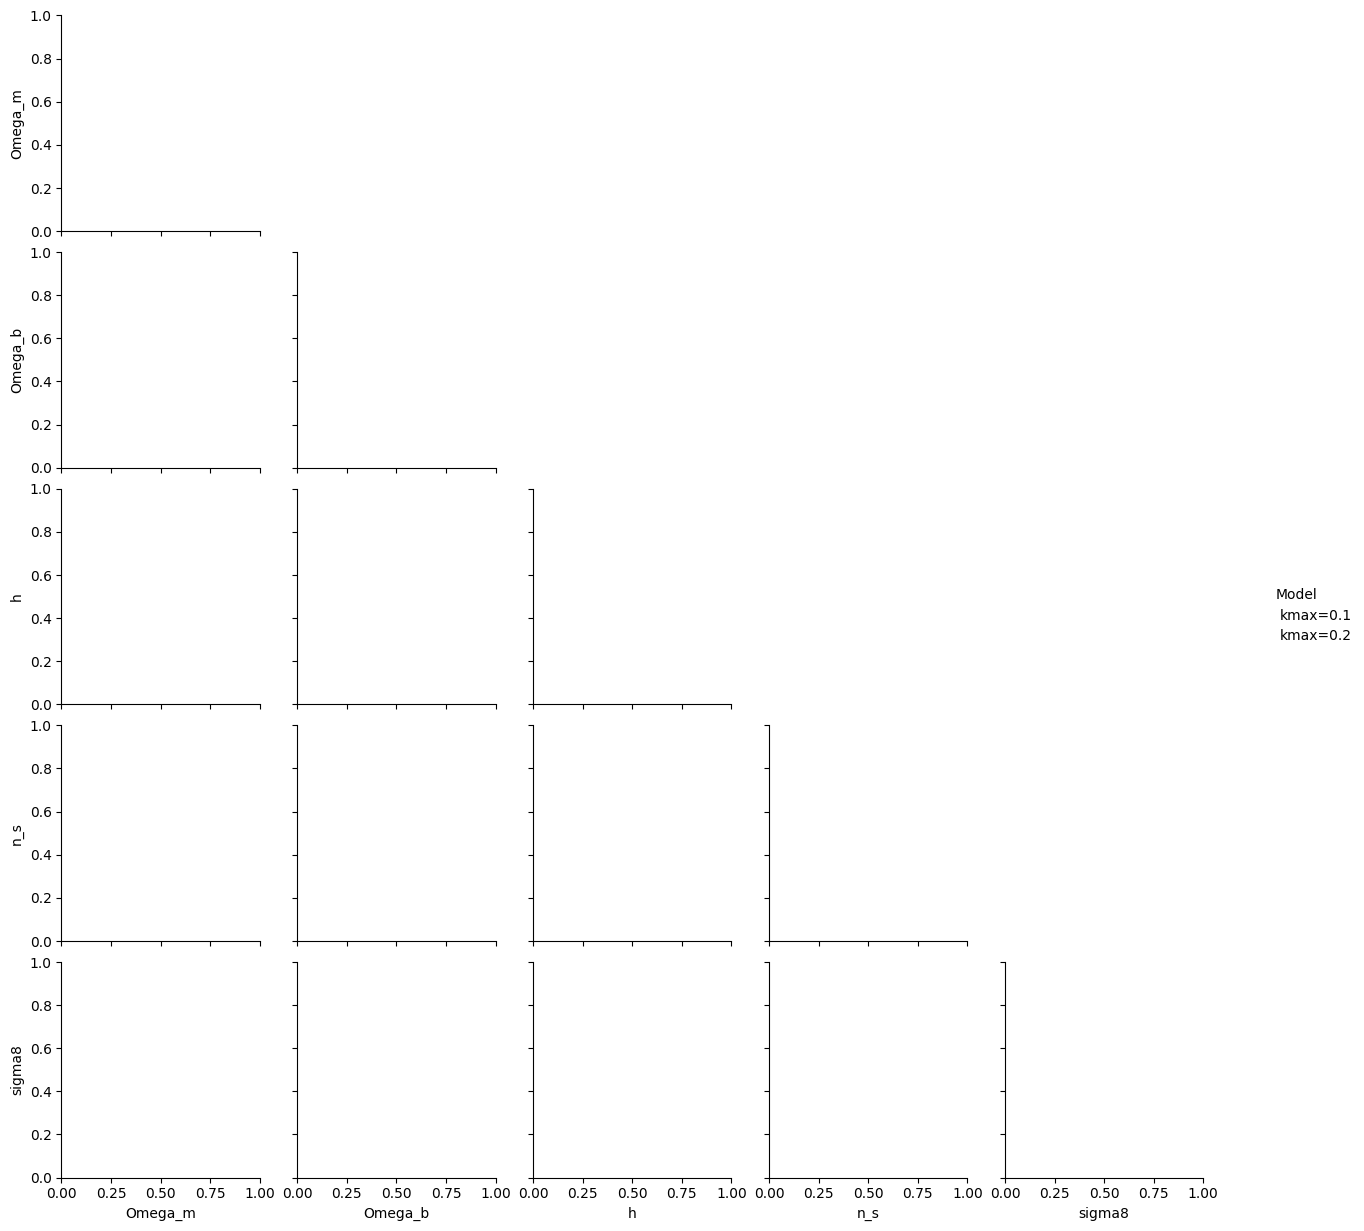

In [14]:
metric = PlotSinglePosterior(
    num_samples=1000, sample_method='direct',
    labels=['Omega_m', 'Omega_b', 'h', 'n_s', 'sigma8']
)
fig = None
for i, kmax in enumerate(kmaxs):
    print(kmax)
    xobs = Pktest[:, :, 0]
    mask = ktest[0] < kmax
    xobs = xobs[:, mask]
    xobs = np.log10(xobs)
    xobs = impute(xobs)
    _p = posteriors[kmax]
    fig = metric(
        posterior=_p,
        x_obs = xobs[10], theta_fid = cosmotest[10],
        grid=fig,
        name=f'kmax={kmax}'
    )

In [17]:
kmax = 0.2
_p = posteriors[kmax]
xobs = Pktest[:, :, 0]
mask = ktest[0] < kmax
xobs = xobs[:, mask]
xobs = np.log10(xobs)
xobs = impute(xobs)
i = 10
xobs[i], cosmotest[i]

(array([4.90800588, 5.05234332, 4.98732622, 5.00007802, 4.78487919,
        4.68522103, 4.58657299, 4.58444591, 4.5434258 , 4.48828488,
        4.44941196, 4.39163426, 4.36146868, 4.31357489, 4.27089443,
        4.19671728, 4.17440162, 4.1362215 , 4.12401909, 4.1053775 ,
        4.10623826, 4.06321981, 4.05563264, 4.02239652, 4.00554647,
        3.97693677, 3.95572035, 3.93388724, 3.92238626, 3.91846862,
        3.91509029]),
 array([0.2895 , 0.04181, 0.5033 , 0.9055 , 0.7353 ]))

INFO:root:Sampling models with tensor([1000.]) samples each.
Drawing 1000 posterior samples: 1280it [00:00, 35174.67it/s]            

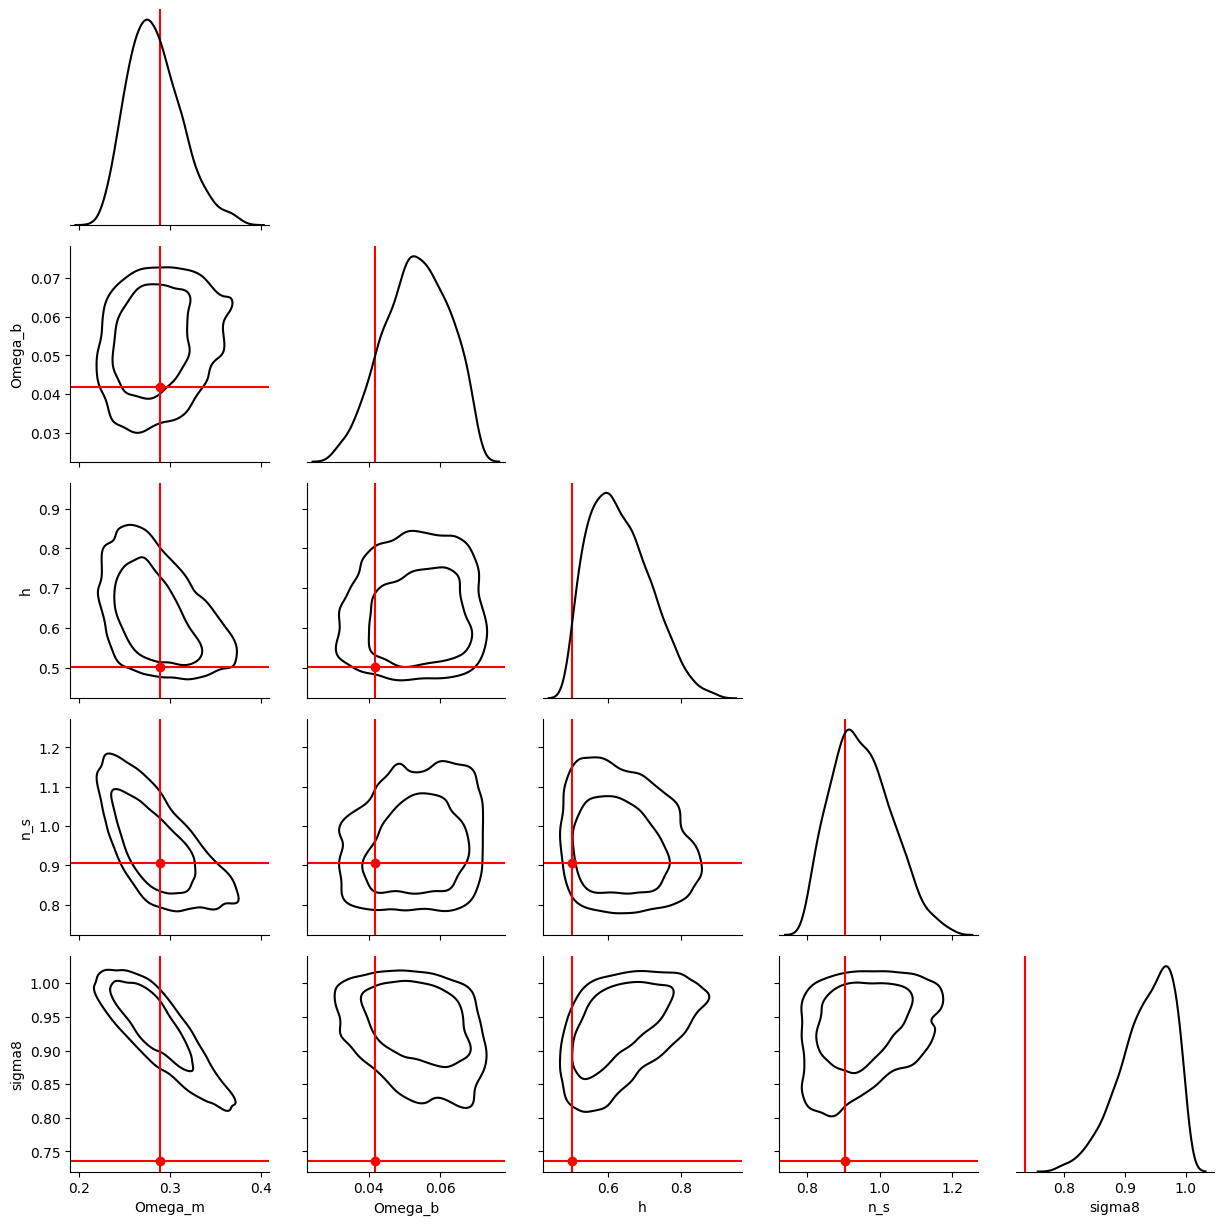

In [18]:
metric = PlotSinglePosterior(
    num_samples=1000, sample_method='direct',
    labels=['Omega_m', 'Omega_b', 'h', 'n_s', 'sigma8']
)
fig = metric(
    posterior=_p,
    x_obs = xobs[10], theta_fid = cosmotest[10],
    grid=None,
    name=f'kmax={kmax}'
)

  2%|▏         | 41/1903 [00:06<02:51, 10.83it/s]

/home/mattho/git/ltu-ili/ili/utils/ndes_pt.py:174: UserWarning: Direct sampling took too long. The posterior is poorly constrained within the prior support. Consider using emcee sampling or using a larger prior support. Returning prior samples.
  warnings.warn(
100%|██████████| 1903/1903 [03:12<00:00,  9.89it/s]
INFO:root:Mean logprob: -1.7484e+03Median logprob: -9.3360e+02
100%|██████████| 100/100 [00:18<00:00,  5.40it/s]
INFO:matplotlib.mathtext:Substituting symbol E from STIXNonUnicode


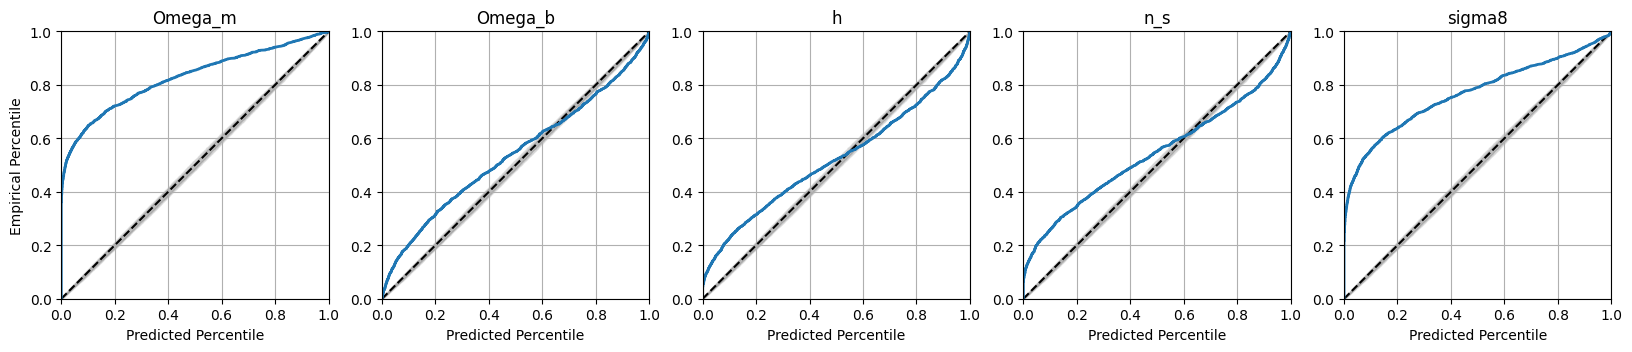

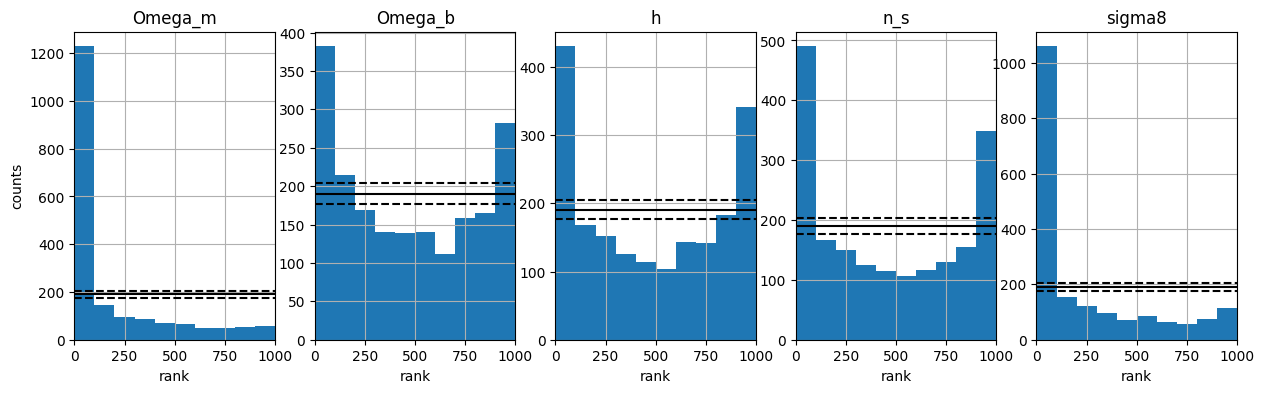

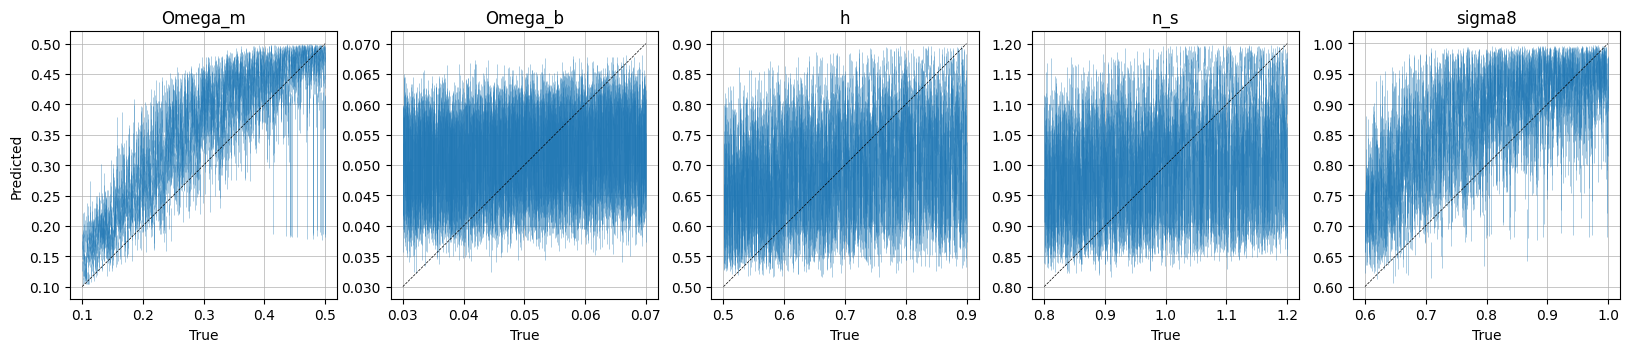

INFO:matplotlib.mathtext:Substituting symbol E from STIXNonUnicode


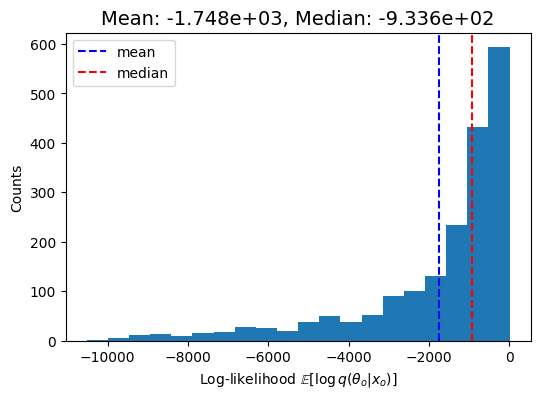

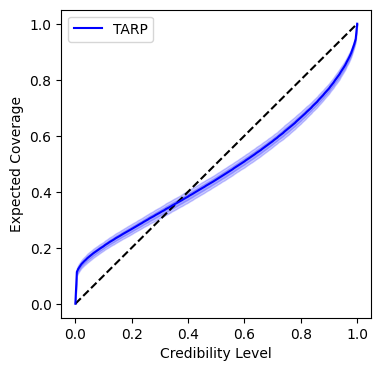

In [16]:
metric = PosteriorCoverage(
    num_samples=1000, sample_method='direct', 
    labels=['Omega_m', 'Omega_b', 'h', 'n_s', 'sigma8'],
    plot_list = ["coverage", "histogram", "predictions", "tarp", "logprob"],
    out_dir=None
)
metric(posterior=_p, x=xobs, theta=cosmotest);

## Scratch

### Fix P(k) descrepancy

In [19]:
np.argwhere(np.all(cosmotrain[5] == cosmotest, axis=1))

array([[1237]])

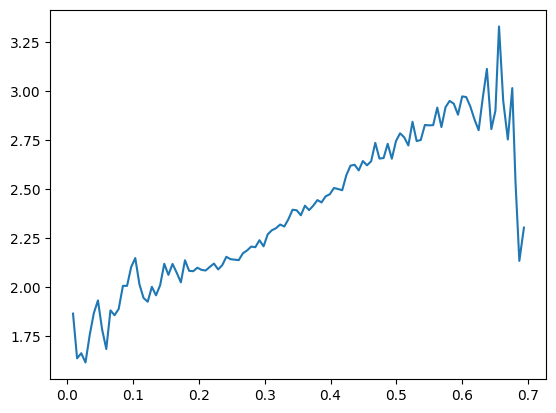

In [21]:
# plt.loglog()
plt.plot(ktrain[5], Pktrain[5, :, 0]/Pktest[1237, :, 0])
# plt.plot(ktest[3], )

In [8]:
from cmass.bias.apply_hod import load_snapshot
from cmass.bias.rho_to_halo import save_snapshot


/automnt/data80/mattho/cmass-ili/quijotelike/fastpm/L1000-N128/3
(304248, 3)


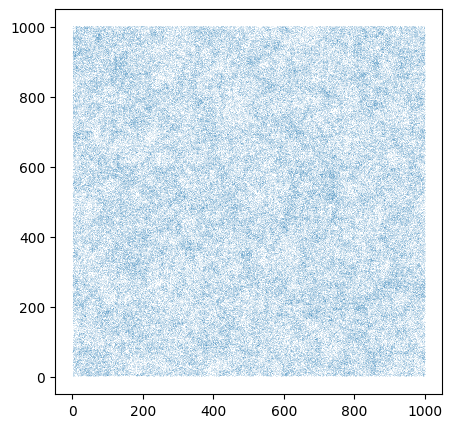

In [10]:
# Train suite
suite = 'quijotelike'
sim = 'fastpm'
L, N = 1000, 128


from cmass.utils import get_source_path

source_path = get_source_path(wdir, suite, sim, L, N, 3)
print(source_path)

af = 1/(1+0.5)
lpos, lvel, lmass = load_snapshot(source_path, af)
print(lpos.shape)
with h5py.File(join(source_path, 'diag', 'halos.h5'), 'r') as f:
    a = list(f.keys())[-1]
    lkd = f[a]['Pk_k'][:]
    lPkd = f[a]['Pk'][:]

f, ax = plt.subplots(figsize=(5,5))
ax.plot(lpos[:,0], lpos[:,1], ',', alpha=0.1)

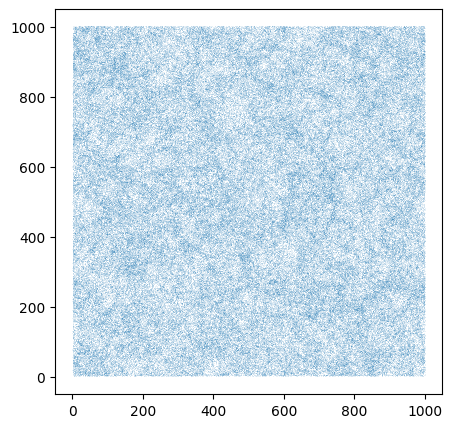

In [11]:
# Test suite
suite = 'quijote'
sim = 'nbody'
L, N = 1000, 128

from cmass.utils import get_source_path

source_path = get_source_path(wdir, suite, sim, L, N, 3)

af = 1/(1+0.5)
qpos, qvel, qmass = load_snapshot(source_path, af)
with h5py.File(join(source_path, 'diag', 'halos.h5'), 'r') as f:
    a = list(f.keys())[-1]
    qkd = f[a]['Pk_k'][:]
    qPkd = f[a]['Pk'][:]

f, ax = plt.subplots(figsize=(5,5))
ax.plot(qpos[:,0], qpos[:,1], ',', alpha=0.1)

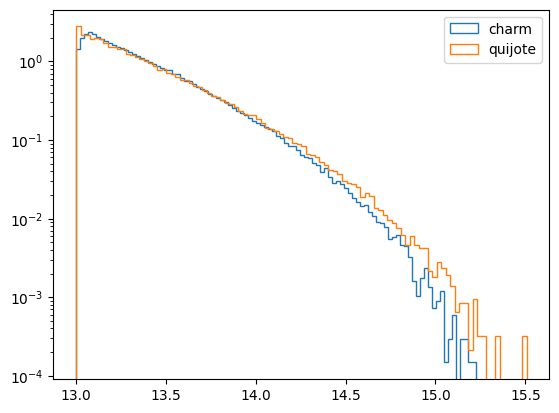

In [13]:
plt.semilogy()
plt.hist(lmass, bins=100, histtype='step', label='charm', density=True)
plt.hist(qmass, bins=100, histtype='step', label='quijote', density=True)
plt.legend();

In [31]:
ldelta.mean()

1.4770194e-08

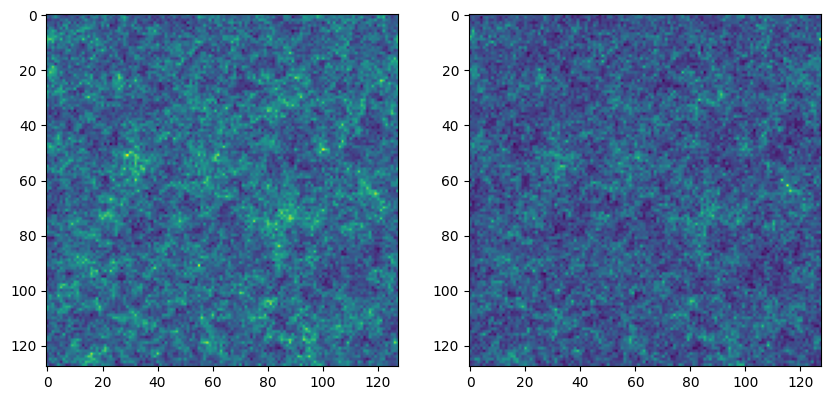

In [32]:
from cmass.diagnostics.tools import MA, MAz, calcPk

ldelta = MA(lpos, L, N, MAS='NGP')
qdelta = MA(qpos, L, N, MAS='NGP')

# ldelta /= ldelta.mean()
# qdelta /= qdelta.mean()
# ldelta -= 1
# qdelta -= 1

f, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].imshow(ldelta.sum(axis=0))
axs[1].imshow(qdelta.sum(axis=0))

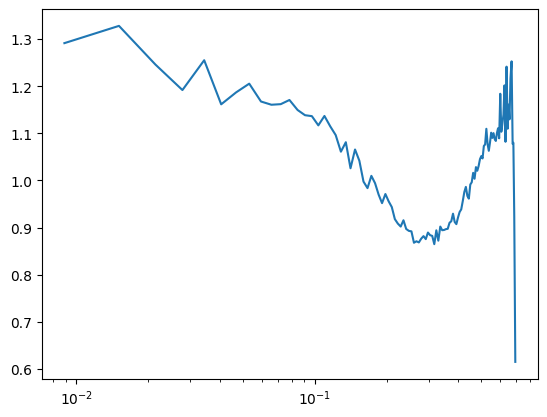

In [33]:
k, lPk = calcPk(ldelta, L, MAS='NGP')
k, qPk = calcPk(qdelta, L, MAS='NGP')

plt.semilogx(k, lPk[...,0]/qPk[...,0]);

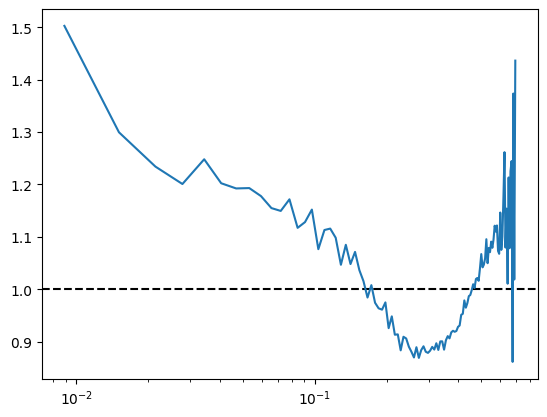

In [34]:
plt.axhline(1, c='k', ls='--')
plt.semilogx(lkd, lPkd[...,0]/qPkd[...,0])

### Fix quijote mass cut

In [105]:
from cmass.bias.apply_hod import load_snapshot
from cmass.bias.rho_to_halo import save_snapshot

# Test suite
suite = 'quijote'
sim = 'nbody'
L, N = 1000, 128

from cmass.utils import get_source_path

suite_path = get_source_path(wdir, suite, sim, L, N, 0)[:-2]

for lhid in tqdm(os.listdir(suite_path)):
    a = 1/(1+0.5)
    hpos, hvel, hmass = load_snapshot(join(suite_path, lhid), a)

    mask = hmass > 13
    hpos, hvel, hmass = hpos[mask], hvel[mask], hmass[mask]

    os.remove(join(suite_path, lhid, 'halos.h5'))
    save_snapshot(join(suite_path, lhid), a, hpos, hvel, hmass)

100%|██████████| 2000/2000 [07:33<00:00,  4.41it/s]


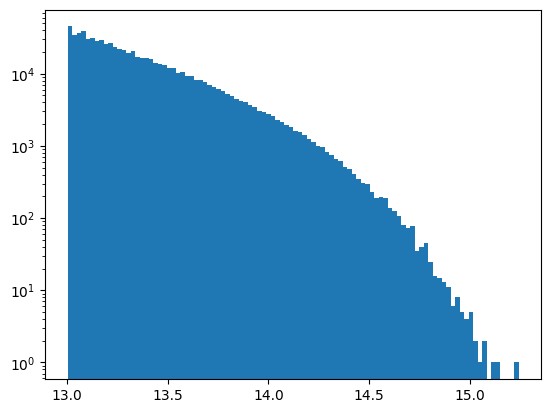

In [106]:
plt.semilogy()
plt.hist(hmass, bins=100);